# Toy examples using Stan

I estimate the Preston, box-cox, and log quadratic model using data from 1950+. Are these models comparable? No, but the Jacobian adjustment should do the trick. I am not sure if I am doing the correct thing, need some math assistance.

Next steps: 

- Check if my adjustment of the log-likelihood to make models comparable is correct. For instance: 

  ```log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma) + (lambda-1)*log(y[n]);```
  
- Find a solution for invalid box-cox posterior values
- Create function to average predictions using stacking weights
- Think about reasonable priors to use
- Which LE estimates to use?
- Function to compute delta values
- Get distribution of final estimates 

Something else?

In [60]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

library(loo)
library(haven)
library(sdazar)
library(MASS)
library(ggplot2)

options(repr.plot.width = 7, repr.plot.height = 4)
source('Rutils/functions.R')

## Using real data (1950 or more)

In [2]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, tle := le/(1.05*max(le))]

df49 = copy(df)[year < 1950]
df50 = copy(df)[year >= 1950]

# using >=50
data = list(
    N = nrow(df50),
    x = df50$gdp, 
    y = df50$tle
)

saveRDS(data, '../data/example.rds')

# Preston Model

## Frequentist

In [3]:
# estimating starting values for the parameters. 
# Assume alpha=1, then estimate logit(yvar)=beta+gamma^GDP

In [4]:
pars = nls(log(y) ~ beta+exp(log(C)*x),
      data=data,
      start=list(beta=1,C=1))

In [5]:
nlsFormula = "y ~ alpha / (1 + exp( beta + exp(log(C) * x )))"
nlsInitial = c(alpha=max(data$y),coef(pars)[1],coef(pars)[2])

In [6]:
model_preston = minpack.lm::nlsLM(formula = nlsFormula,
         data=data,
         start=nlsInitial,
     control=minpack.lm::nls.lm.control(maxiter=1000))

In [7]:
summary(model_preston)


Formula: y ~ alpha/(1 + exp(beta + exp(log(C) * x)))

Parameters:
       Estimate Std. Error  t value Pr(>|t|)    
alpha 2.6615949  1.0526279    2.529   0.0121 *  
beta  0.6915597  0.6118753    1.130   0.2595    
C     0.9995341  0.0001052 9505.206   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09476 on 237 degrees of freedom

Number of iterations to convergence: 11 
Achieved convergence tolerance: 1.49e-08


## Stan

In [8]:
stan_preston = '
    data {
      int<lower=0> N; 
      real x[N]; 
      real y[N]; 
    } 
    parameters {
      real alpha; 
      real beta;  
      real<lower=.5,upper= 1> C;
      real<lower=0> sigma; 
    } 
    model {
      real m[N];
      
      alpha ~ normal(0, 2); 
      beta ~ normal(0, 2); 
      C ~ uniform(0, 1); 
      
      for (i in 1:N) 
        m[i] = alpha / ( 1 + exp ( beta + exp ( log(C) * x[i])));

      y ~ normal(m, sigma); 

      }
    generated quantities{
      real y_pred[N];
      real log_lik[N];

      for(i in 1:N){
        y_pred[i] = normal_rng(alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma);   
        log_lik[i] = normal_lpdf(y[i] | alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma); // no need of adjustment
     }
    }
'

In [9]:
fit_preston = stan(model_code = stan_preston, 
            model_name = "preston", 
            data = data)

In [10]:
print(fit_preston, pars=c('alpha', 'beta', 'C', 'sigma'))

Inference for Stan model: preston.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean   sd  2.5%  25%  50%  75% 97.5% n_eff Rhat
alpha 2.73    0.03 0.78  1.75 2.18 2.55 3.07  4.71   630    1
beta  0.65    0.01 0.40 -0.05 0.36 0.62 0.91  1.48   750    1
C     1.00    0.00 0.00  1.00 1.00 1.00 1.00  1.00   991    1
sigma 0.10    0.00 0.00  0.09 0.09 0.10 0.10  0.10  1626    1

Samples were drawn using NUTS(diag_e) at Fri Feb 16 10:08:17 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [11]:
# leave-one-out
loo(extract_log_lik(fit_preston, parameter_name = 'log_lik'))

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    223.1 10.7
p_loo         3.2  0.4
looic      -446.3 21.3

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

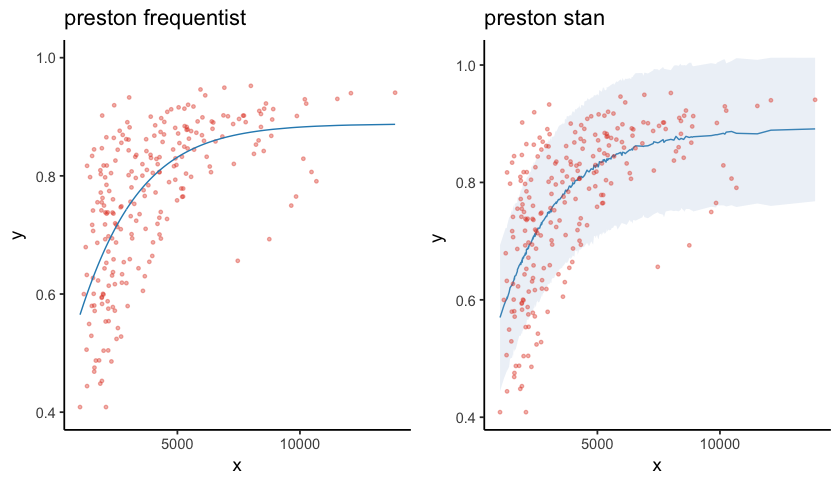

In [12]:
# plots
plot1 = plot_predictions(data$x,data$y, pred=predict(model_preston)) + ylim(0.4, 1.0) + labs(title='preston frequentist')
plot2 = plot_posterior(fit_preston, data$x, data$y) + labs(title='preston stan')
gridExtra::grid.arrange(plot1, plot2, ncol=2)

# Boxcox

## Frequentist

In [13]:
bc = boxcox(data$y~log(data$x),plotit=FALSE,lambda=seq(0,3,0.01))

In [14]:
lambda = bc$x[bc$y==max(bc$y)]

In [15]:
if(lambda==0) {y = log(data$y)}
if(lambda!=0) {y = (data$y^lambda -1)/lambda}
model_bc = lm(y ~ log(data$x))

In [16]:
summary(model_bc)


Call:
lm(formula = y ~ log(data$x))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.126565 -0.038603  0.003343  0.031777  0.132856 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.831259   0.046857  -17.74   <2e-16 ***
log(data$x)  0.080593   0.005726   14.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05027 on 238 degrees of freedom
Multiple R-squared:  0.4543,	Adjusted R-squared:  0.452 
F-statistic: 198.1 on 1 and 238 DF,  p-value: < 2.2e-16


## Stan

In [17]:
stan_boxcox = '
    data {
        int<lower=0> N;
        real x[N]; 
        real y[N]; 
    }

    parameters {
        real alpha;
        real beta;
        real lambda;
        real<lower=0> sigma;
    }

    model {
        lambda ~ normal(0,3);
        beta ~ normal(0,0.5);
        alpha ~ normal(0,2);
        sigma ~ cauchy(0, 5);

        if (lambda == 0) {
            for(i in 1:N) {
                    log(y[i]) ~ normal(alpha + log(x[i])*beta, sigma);
                    target += -log(y[i]);
            }
        } else {
            for(i in 1:N){
                    (y[i]^lambda - 1)/lambda ~ normal(alpha + log(x[i])*beta, sigma);
                    target += (lambda - 1)*log(y[i]);
                }
            }
        }

    generated quantities {

       real y_pred[N];
       real log_lik[N];
       int i;

    for(n in 1:N){
           if(lambda != 0) {
             
            // this is crude and potentially problematic solution!
            // discarding problematic posterior values

             i = 1;
             while ((is_nan(y_pred[n])) && (i <= 1000)) {
                y_pred[n] = ((normal_rng(alpha + log(x[n])*beta, sigma)) * lambda + 1)^(1/lambda);
                i = i + 1;
             }

             if (is_nan(y_pred[n])) {
               y_pred[n] = 0; // very crude solution!
             } 
               
            //if(is_nan(y_pred[n])) { // for assessing bugs
                //print(alpha);
                //print(log(x[n]));
                //print(beta);
                //print(sigma);
                //print(lambda);
            //}

             log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma) + (lambda-1)*log(y[n]); // is this right?
            //log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma);
            
            } else {
             y_pred[n] = exp(normal_rng(alpha + log(x[n])*beta, sigma));
             log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma) - log(y[n]); // this is right!
            //log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma);

           }
         }
    }
    '

In [18]:
fit_boxcox = stan(model_code = stan_boxcox, 
            model_name = 'boxcox', 
            data = data)

In [19]:
print(fit_boxcox, pars=c('alpha', 'beta', 'lambda', 'sigma'))

Inference for Stan model: boxcox.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  -0.85    0.00 0.09 -1.05 -0.91 -0.85 -0.79 -0.69   741    1
beta    0.08    0.00 0.01  0.06  0.08  0.08  0.09  0.11   754    1
lambda  2.93    0.01 0.36  2.25  2.69  2.92  3.17  3.61   811    1
sigma   0.05    0.00 0.01  0.04  0.05  0.05  0.06  0.06   831    1

Samples were drawn using NUTS(diag_e) at Fri Feb 16 10:09:39 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [20]:
loo(extract_log_lik(fit_boxcox, parameter_name = 'log_lik'))

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    237.0 11.9
p_loo         3.6  0.4
looic      -474.0 23.8

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

### Look at the uncertainty in the lowest GDP values!

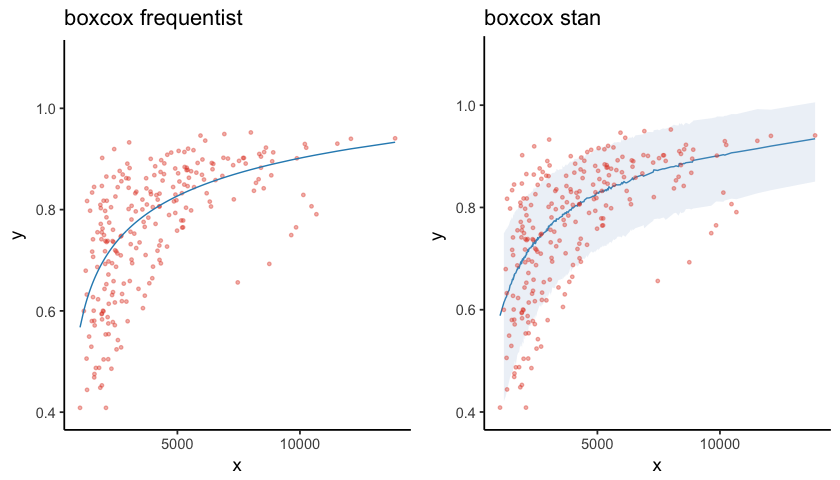

In [21]:
options(repr.plot.width = 7, repr.plot.height = 4)
plot1 = plot_predictions(data$x, data$y, pred_bc(predict(model_bc), lambda=lambda)) + ylim(0.4, 1.1) + labs(title='boxcox frequentist')
plot2 = plot_posterior(fit_boxcox, data$x, data$y, 'y_pred') + labs(title='boxcox stan') + ylim(0.4, 1.1)
gridExtra::grid.arrange(plot1, plot2, ncol=2)

### Problem transforming extreme values from posterior distribution

What to do? Discussion here: http://discourse.mc-stan.org/t/problem-recovering-generated-predictions-for-box-cox-model/3315

In [22]:
# example using data estimated by stan
alpha = -1.26999
logx = 7.90211
beta = 0.101912
lambda = 1.05
sigma = 0.316502

In [23]:
a = rnorm(100, alpha + beta*logx, sigma) # get random values from normal distriution

df = data.table(value = a, tf = (a * lambda + 1)^(1/lambda))
df[is.na(df$tf),] # not able to transform extreme numbers

value,tf
-1.100989,NaN
-1.521541,NaN
-1.099311,NaN
-1.161007,NaN
-1.258452,NaN
-1.346743,NaN
-1.366227,NaN


In [24]:
setorder(df, value)
head(df)

value,tf
-1.521541,NaN
-1.366227,NaN
-1.346743,NaN
-1.258452,NaN
-1.161007,NaN
-1.100989,NaN


In the solution presented above with stan, I just discarded posterior values that produce complex numbers. 

# Log and quadratic model

Equivalent to the box-cox with lamda = 0.

## Frequentist

In [25]:
model_log = lm(log(data$y) ~ 1 + log(data$x))

In [26]:
summary(model_log)


Call:
lm(formula = log(data$y) ~ 1 + log(data$x))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50073 -0.07016  0.01862  0.09313  0.30706 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.9819     0.1318  -15.04   <2e-16 ***
log(data$x)   0.2077     0.0161   12.90   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1413 on 238 degrees of freedom
Multiple R-squared:  0.4117,	Adjusted R-squared:  0.4092 
F-statistic: 166.5 on 1 and 238 DF,  p-value: < 2.2e-16


## Stan

In [27]:
stan_log = '
    data {
        int<lower=0> N;
        real y[N];
        real x[N];
    }

    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }

    model {
        beta ~ normal(0,2);
        alpha ~ normal(-7,1);

        for (i in 1:N) {
            log(y[i]) ~ normal(alpha + log(x[i])*beta, sigma);
            //target += -log(y[i]);
        }
}

    generated quantities {
       vector[N] y_pred;
       vector[N] log_lik;
        
        for (n in 1:N) {
        log_lik[n] = normal_lpdf(log(y[n]) | alpha +  log(x[n])*beta, sigma) - log(y[n]);
        y_pred[n] = exp(normal_rng(alpha + log(x[n])*beta, sigma));
         }
        }
    '

In [28]:
fit_log = stan(model_code = stan_log, 
            model_name ='log',
            data = data)

In [29]:
print(fit_log, pars=c('alpha', 'beta', 'sigma'))

Inference for Stan model: log.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha -2.07       0 0.13 -2.32 -2.16 -2.07 -1.97 -1.81   945    1
beta   0.22       0 0.02  0.19  0.21  0.22  0.23  0.25   936    1
sigma  0.14       0 0.01  0.13  0.14  0.14  0.15  0.16  1609    1

Samples were drawn using NUTS(diag_e) at Fri Feb 16 10:10:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [30]:
#traceplot(fit_log, pars=c('alpha', 'beta', 'sigma'))

In [31]:
loo(extract_log_lik(fit_log, parameter_name = 'log_lik'))

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    195.1 11.0
p_loo         3.4  0.5
looic      -390.3 22.0

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

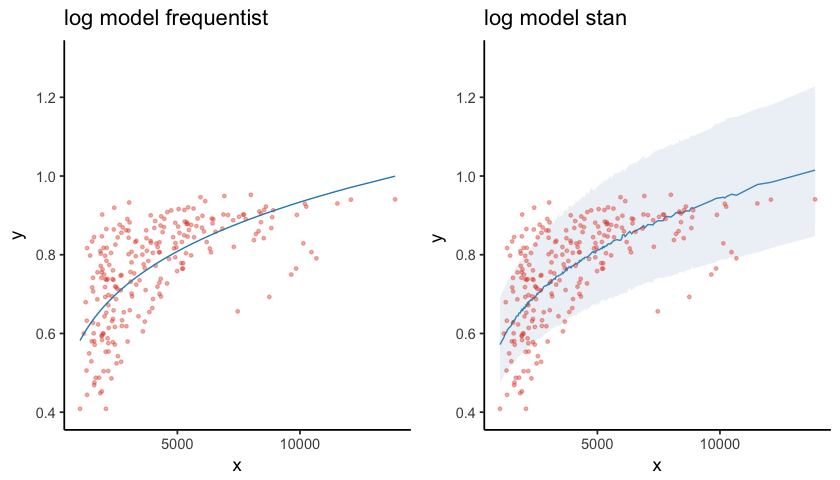

In [32]:
plot1 = plot_predictions(data$x, data$y, exp(predict(model_log))) + ylim(0.4, 1.3) + labs(title='log model frequentist')
plot2 = plot_posterior(fit_log, data$x, data$y) + ylim(0.4, 1.3) + labs(title='log model stan')
gridExtra::grid.arrange(plot1, plot2, ncol=2)

# Averaging or stacking

In [33]:
log_lik_list = list()
log_lik_list[[1]] = extract_log_lik(fit_preston, parameter_name = 'log_lik')
log_lik_list[[2]] = extract_log_lik(fit_log, parameter_name = 'log_lik') 
log_lik_list[[3]] = extract_log_lik(fit_boxcox, parameter_name = 'log_lik') 

In [111]:
loo::model_weights(log_lik_list, method='stacking')

The stacking weights are:
     [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "0"       "1"      


[1] 3.046038e-04 2.687532e-08 9.996954e-01

In [113]:
loo::model_weights(log_lik_list, method='pseudobma')

The Pseudo-BMA+ weights using Bayesian Bootstrap  are:
      [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0.01"    "0"       "0.99"   


[1] 5.381597e-03 2.468936e-12 9.946184e-01

Difference between  models is pretty strong... averaging is giving weight 1 to one of the models (box-cox), in other words, no need to average but to use the best model!

In [115]:
# get combine predictions using stacking

In [107]:
models = list()
models[[1]] = fit_preston
models[[2]] = fit_log
models[[3]] = fit_boxcox

In [108]:
sum(w) # check weights sum 1

[1] 1

In [116]:
options(repr.plot.width = 4, repr.plot.height = 4)

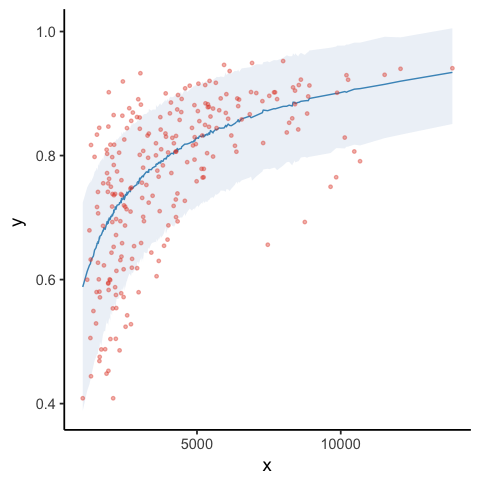

In [117]:
plot_posterior_w(models, w, data$x, data$y)